### Same task with feature extraction

Load modules 

In [2]:
# base tools
import os, sys
sys.path.append(os.path.join(".."))

# data analysis
import numpy as np
import pandas as pd
from numpy.linalg import norm
from tqdm import tqdm
from sklearn.neighbors import NearestNeighbors

# tensorflow
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
# from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

# style utils 
sys.path.append(os.path.join("..", "CDS-VIS"))
from utils.styletransfer import *

# matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

2022-05-14 15:37:03.853304: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-14 15:37:03.853360: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


ModuleNotFoundError: No module named 'utils'

Define extraction function 

In [3]:
def extract_features(img_path, model):

    # Define input image shape to fit VGG16
    input_shape = (224, 224, 3)
    # load image from file path
    img = load_img(img_path, target_size=(input_shape[0], 
                                          input_shape[1]))
    # convert to array
    img_array = img_to_array(img)
    # expand to fit dimensions
    expanded_img_array = np.expand_dims(img_array, axis=0)
    # preprocess image to match VGG16 
    preprocessed_img = preprocess_input(expanded_img_array)
    # use the predict function to create feature representation
    features = model.predict(preprocessed_img)
    # flatten
    flattened_features = features.flatten()
    # normalise features
    normalized_features = flattened_features / norm(features)
    
    return normalized_features

Define model

In [4]:
# Load VGG-16 
model = VGG16(weights="imagenet", 
                pooling = "avg",
                include_top = False,
                input_shape = (224, 224, 3))

2022-05-14 15:37:11.484546: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-05-14 15:37:11.484594: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (j-70914-job-0): /proc/driver/nvidia/version does not exist
2022-05-14 15:37:11.619785: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


58900480/58889256 [==============================] - 1s 0us/step


Getting list of files in directory 

In [5]:
# > Get list of filenames
def get_filenames():
    # Get all files in directory (sorted)
    file_list = sorted(os.listdir(DIRECTORY_PATH))
    # remove '.ipynb_checkpoints'
    flower_list = list(filter(lambda x: x.startswith("image"), file_list))
    
    return flower_list

In [6]:
DIRECTORY_PATH = os.path.join("..", "..", "..", "..", "CDS-VIS", "flowers")

In [7]:
flower_list = get_filenames()

Extract features 

In [8]:
feature_list = []
for flower in tqdm(flower_list):
    input_path = os.path.join(DIRECTORY_PATH, flower)
    features = extract_features(input_path, model)
    feature_list.append(features)

100%|██████████| 1360/1360 [03:04<00:00,  7.36it/s]


In [12]:
len(feature_list)

1360

Define nearest neighbors algorithm

In [13]:
neighbors = NearestNeighbors(n_neighbors=10,
                            algorithm = "brute",
                            metric = "cosine").fit(feature_list)

Calculate nighbors for target 

In [71]:
# Finding target flower from filename
reference_index = flower_list.index("image_1301.jpg")

In [72]:
distances, indices = neighbors.kneighbors([feature_list[reference_index]]) 
# First array is cosine similarity, second array is indices of images (target is, in this case, flower 1300)

In [63]:
distances

array([[0.        , 0.22077489, 0.236682  , 0.25796872, 0.2864688 ,
        0.29327756, 0.308999  , 0.3103974 , 0.31450522, 0.3228224 ]],
      dtype=float32)

find indecies for nearest neighbors 

In [26]:
range(1, 6)

range(1, 6)

In [27]:
indices

array([[ 41,   1,  50,  27,  57, 563,  32,  45,  33, 603]])

In [73]:
idxs = []
for i in range(1,4):
    idxs.append(indices[0][i])

In [74]:
idxs

[1345, 1341, 1314]

Get distances of the 3 nearet

In [75]:
dists = []
for i in range(1,4):
    dists.append(distances[0][i])

In [1]:
# Lets just assume that they are ordered, even if it is weird
dists

NameError: name 'dists' is not defined

Create nearest neighbor function 

In [13]:
def nearest_neighbors(reference_index):
    # Define nearest neighbors algorithm
    neighbors = NearestNeighbors(n_neighbors=10,
                                algorithm = "brute",
                                metric = "cosine").fit(feature_list)
   
    # Calculate nearest neighbors
    distances, indices = neighbors.kneighbors([feature_list[reference_index]])
    
    # Getting indices of nearest neighbors
    three_indices = []
    for i in range(1,4):
        three_indices.append(indices[0][i])
    
    # Getting cosine distances of nearest neighbors 
    three_distances = []
    for i in range(1,4):
        three_distances.append(distances[0][i])
    
    return three_indices, three_distances
    

In [11]:
# Finding target flower from filename
reference_index = flower_list.index("image_1301.jpg")

In [14]:
indices, distances = nearest_neighbors(reference_index)

In [15]:
indices

[1345, 1341, 1314]

In [16]:
distances

[0.074225605, 0.116737366, 0.12364799]

Create nearest neighbors df

In [36]:
def create_csv(reference, idxs):
    # Gather 3 closest 
    data = (reference, flower_list[idxs[0]], flower_list[idxs[1]], flower_list[idxs[2]])
    # Create dataframe
    df = pd.DataFrame([data], columns=["reference", "first", "second", "third"])
    # Save CSV
    #outpath = os.path.join("output", "neighbor_df.csv")
    #df.to_csv(outpath, index=False)
    
    return (df)

In [76]:
df = create_csv("image_1301.jpg", idxs)

In [77]:
df

,reference,first,second,third
0,image_1301.jpg,image_1346.jpg,image_1342.jpg,image_1315.jpg


Plotting 

In [51]:
def plot_img(df, dists):
    # Load correct images (rgb, not bgr)
    rgb_reference = mpimg.imread(os.path.join(DIRECTORY_PATH, df["reference"][0]))
    rgb_first = mpimg.imread(os.path.join(DIRECTORY_PATH, df["first"][0]))
    rgb_second = mpimg.imread(os.path.join(DIRECTORY_PATH, df["second"][0]))
    rgb_third = mpimg.imread(os.path.join(DIRECTORY_PATH, df["third"][0]))
    
    # Create plot
    f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15,15))
    ax1.imshow(rgb_reference)
    ax1.set_title(f'Rererence:\n {df["reference"][0]}')
    ax2.imshow(rgb_first)
    ax2.set_title(f'{df["first"][0]}:\n {dists[0]}')
    ax3.imshow(rgb_second)
    ax3.set_title(f'{df["second"][0]}:\n {dists[1]}')
    ax4.imshow(rgb_third)
    ax4.set_title(f'{df["third"][0]}:\n {dists[0]}')

    # Saving image
    # plt.savefig(os.path.join("output", "comparison_img.png"))

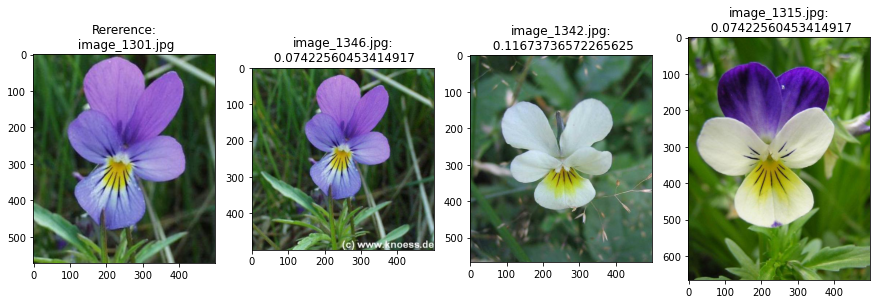

In [78]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plot_img(df, dists)